# Sentiment classification

Below are imports and helper functions from previous classification labs. The task for this week is to build your own classifier for predicting the sentiment of Tweets. Tweets are provided from [SemEval-2016 Task 4 (Subtask A)](http://alt.qcri.org/semeval2016/task4/).

In [1]:
import ftfy
import nltk
import json

from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import Binarizer

import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import re

from collections import Counter
from os import listdir, makedirs
from os.path import isfile, join, splitext, split

For POS tagger, incase these haven't been previously downloaded.

In [2]:
nltk.download('punkt')
nltk.download('maxent_treebank_pos_tagger')

[nltk_data] Downloading package punkt to /home/jay/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package maxent_treebank_pos_tagger to
[nltk_data]     /home/jay/nltk_data...
[nltk_data]   Package maxent_treebank_pos_tagger is already up-to-
[nltk_data]       date!


True

A couple of methods for showing classifier results (from 1st classification lab):

In [3]:
def print_cv_scores_summary(name, scores):
    print("{}: mean = {:.2f}%, sd = {:.2f}%, min = {:.2f}, max = {:.2f}".format(name, scores.mean()*100, scores.std()*100, scores.min()*100, scores.max()*100))
    
def confusion_matrix_heatmap(cm, index):
    cmdf = pd.DataFrame(cm, index = index, columns=index)
    dims = (10, 10)
    fig, ax = plt.subplots(figsize=dims)
    sns.heatmap(cmdf, annot=True, cmap="coolwarm", center=0)
    ax.set_ylabel('Actual')    
    ax.set_xlabel('Predicted')
    
def confusion_matrix_percent_heatmap(cm, index):
    cmdf = pd.DataFrame(cm, index = index, columns=index)
    percents = cmdf.div(cmdf.sum(axis=1), axis=0)*100
    dims = (10, 10)
    fig, ax = plt.subplots(figsize=dims)
    sns.heatmap(percents, annot=True, cmap="coolwarm", center=0, vmin=0, vmax=100)
    ax.set_ylabel('Actual')    
    ax.set_xlabel('Predicted')
    cbar = ax.collections[0].colorbar
    cbar.set_ticks([0, 25, 50, 75, 100])
    cbar.set_ticklabels(['0%', '25%', '50%', '75%', '100%'])

In [4]:
hashtag_re = re.compile(r"#\w+")
mention_re = re.compile(r"@\w+")
url_re = re.compile(r"(?:https?://)?(?:[-\w]+\.)+[a-zA-Z]{2,9}[-\w/#~:;.?+=&%@~]*")

def preprocess(text):
    p_text = hashtag_re.sub("[hashtag]",text)
    p_text = mention_re.sub("[mention]",p_text)
    p_text = url_re.sub("[url]",p_text)
    p_text = ftfy.fix_text(p_text)
    return p_text.lower()

tokenise_re = re.compile(r"(\[[^\]]+\]|[-'\w]+|[^\s\w\[']+)") #([]|words|other non-space)
def tokenise(text):
    return tokenise_re.findall(text)

class Document:
    def __init__(self, meta={}):
        self.meta = meta
        self.tokens_fql = Counter() #empty Counter, ready to be added to with Counter.update.
        self.pos_fql = Counter()
        self.pos_list = [] #empty list for pos tags from running text.
        self.num_tokens = 0
        self.text = ""

        
    def extract_features_from_text(self, text):
        self.text += text
        p_text = preprocess(text)
        tokens = tokenise(p_text)
        self.num_tokens += len(tokens)
        self.tokens_fql.update(tokens) #updating Counter counts items in list, adding to existing Counter items.
        pos_tagged = nltk.pos_tag(tokens)
        pos = [tag[1] for tag in pos_tagged]
        self.pos_fql.update(pos)
        self.pos_list.extend(pos)
        
    def extract_features_from_texts(self, texts): #texts should be iterable text lines, e.g. read in from file.
        for text in texts:
            extract_features_from_text(text)

In [5]:
class DocumentProcessor(BaseEstimator, TransformerMixin):
    def __init__(self, process_method):
        self.process_method = process_method
    
    def fit(self, X, y=None): #no fitting necessary, although could use this to build a vocabulary for all documents, and then limit to set (e.g. top 1000).
        return self

    def transform(self, documents):
        for document in documents:
            yield self.process_method(document)

In [6]:
def get_tokens_fql(document):
    return document.tokens_fql

def get_pos_fql(document):
    return document.pos_fql

def read_list(file):
    with open(file) as f:
        items = []
        lines = f.readlines()
        for line in lines:
            items.append(line.strip())
    return items

fws = read_list("functionwords.txt")

def get_fws_fql(document):
    fws_fql = Counter({t: document.tokens_fql[t] for t in fws}) #dict comprehension, t: fql[t] is token: freq.
    return +fws_fql

def get_text_stats(document):
    ttr = len(document.tokens_fql) / document.num_tokens
    return {'avg_token_length': document.average_token_length(), 'ttr': ttr }


Here the Tweets are imported and put into a `Document` instance for each Tweet. This could be edited easily to use in CountVectorizer (as per week 17's lab), just return a list containing the tweet text, and a list containing the labels. All Tweets available from SemEval data are combined here, allowing for our own train/test split or cross-validation.

In [7]:
def import_tweets(file, label):
    metadata = {'label': label}
    with open(file) as f:
        tweets = f.readlines()
        for tweet in tweets:
            doc = Document(meta=metadata)
            doc.extract_features_from_text(tweet)
            yield doc

In [8]:
corpus = []
corpus.extend(import_tweets("sentiment/all/negative.txt", "negative"))
corpus.extend(import_tweets("sentiment/all/positive.txt", "positive"))
corpus.extend(import_tweets("sentiment/all/neutral.txt", "neutral"))

In [9]:
y = [d.meta['label'] for d in corpus]
X = corpus

17804 4452
17804 4452
fitting
Scoring
0.6024258760107817
Accuracy:  0.6024258760107817
              precision    recall  f1-score   support

    negative       0.48      0.42      0.45       667
     neutral       0.60      0.63      0.61      2003
    positive       0.65      0.64      0.64      1782

   micro avg       0.60      0.60      0.60      4452
   macro avg       0.58      0.56      0.57      4452
weighted avg       0.60      0.60      0.60      4452

[[ 282  293   92]
 [ 227 1267  509]
 [  82  567 1133]]


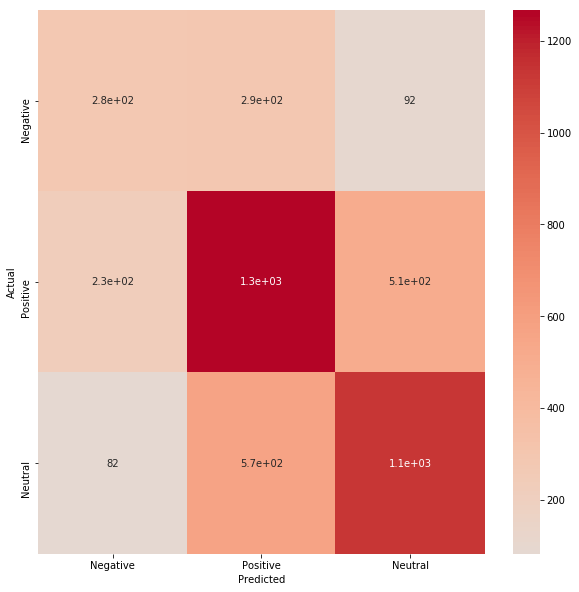

In [10]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import AdaBoostClassifier, VotingClassifier, RandomForestClassifier

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state = 0, stratify=y)
print(len(X_train), len(X_test))
print(len(y_train), len(y_test))

model = Pipeline([
    ('processor', DocumentProcessor(process_method = get_tokens_fql)),
    ('vectorizer', DictVectorizer()),
    ('clf', MLPClassifier()),
])


model = Pipeline([
    ('processor', DocumentProcessor(process_method = get_pos_fql)),
    ('vectorizer', DictVectorizer()),
    ('clf', MLPClassifier()),
])


model = Pipeline([
    ('text_union', FeatureUnion(
        transformer_list = [
            ('pos_features', Pipeline([
                ('pos_processor', DocumentProcessor(process_method = get_pos_fql)),
                ('pos_vectorizer', DictVectorizer()),
            ])),
            ('fws_features', Pipeline([
                ('fws_processor', DocumentProcessor(process_method = get_fws_fql)),
                ('fws_vectorizer', DictVectorizer()),
            ])),
            ('stats_features', Pipeline([
                ('stats_processor', DocumentProcessor(process_method = get_text_stats)),
                ('stats_vectorizer', DictVectorizer()),
            ])),
        ],
    )),
    ('clf', LogisticRegression(solver='liblinear', random_state=0)),
    #('clf', RandomForestClassifier()),
    #('clf', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)),
])


print('fitting')
model.fit(X_train, y_train)
print('Scoring')
print(model.score(X_test,y_test))

predictions = model.predict(X_test)

print("Accuracy: ", accuracy_score(y_test, predictions))
print(classification_report(y_test, predictions))
print(confusion_matrix(y_test, predictions))

confusion_matrix_heatmap(confusion_matrix(y_test,predictions), ['Negative','Positive','Neutral'])



## Task

Using code and features from previous labs, build and evaluate a sentiment classifier, which classifies individual Tweets into `positive`, `negative` or `neutral`.

Marks will be given as follows.
- 3 marks will be given for a well implemented and evaluated with at least 2 advanced feature sets (see below).
- 2 marks will be given for a completed, and evaluated, basic classifier utilising features from previous labs.
- 1 mark will be given for a full attempt.
This exercise must be demonstrated in Week 20's lab.

Advanced feature sets:
- Specific emojis
- Just adjectives
- Words from a sentiment lexicon (e.g. see "Opinion Lexicon" from https://www.cs.uic.edu/~liub/FBS/sentiment-analysis.html#lexicon).
- (very advanced) Word embeddings (ask Andrew in Week 19 lab)

In [11]:
X_train

 ...]